In [36]:
import glob
import json
import gzip
import dill as pickle
import pandas as pd

In [37]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate
from util import calculate_response_parallel

In [38]:
def getresveritas(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['veritas']
def getreskappa(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['lower_threshold']
def getresmu(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['score']
def getres(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['responses']
def getsex(row):
    return row.Sex=='Male'
def getethnicity(row):
    if row['Ethnicity simplified'] == 'White':
        return 0
    if row['Ethnicity simplified'] == 'Black':
        return 1
    if row['Ethnicity simplified'] == 'Asian':
        return 2
    if row['Ethnicity simplified'] == 'Mixed':
        return 3
    return 4

def getpklresp(df):
    A=[{k:v} for k,v in ddf['response'].to_dict().items()]
    with gzip.open('../../response_jsons/experiment2alldata-json.pkl.gz','wb') as file:
        pickle.dump(A,file)

filetimes=pd.read_csv('../../veritas-experiment2/filetimes.csv',names=['sz','creation','jsonpath'])
filetimes.creation = pd.to_datetime(filetimes.creation)
filetimes=filetimes.set_index('creation')
#filetimes=filetimes.sort_index().tail(100)
filetimes=filetimes.reset_index()

In [39]:
de1=pd.read_csv('../../veritas-experiment/prolific_export_659b858e59d89ff7f7340157.csv')
de1=de1[de1.Status=='APPROVED']

de2=pd.read_csv('../../veritas-experiment/prolific_export_659b69ff0a427599bec1d811.csv')
de2=de2[de2.Status=='APPROVED']

de=pd.concat([de1,de2]).assign(batch=0)

In [40]:
demog=pd.read_csv('../../veritas-experiment2/prolific_export_65a96448a2efd0a811b1db33-exp2.csv')
demog=demog[demog.Status!='RETURNED']
demog=demog.assign(batch=1)
demog=pd.concat([demog, de])
demog['Completed at']=pd.to_datetime(demog['Completed at'])
demog=demog.set_index('Completed at')
demog=demog.sort_index().reset_index()

demog=demog.join(filetimes)

ddf=demog[['Participant id','Time taken','Age', 'Sex', 'Ethnicity simplified','jsonpath']].set_index('Participant id')

ddf['veritas']=ddf.apply(getresveritas,axis=1)
ddf['kappa']=ddf.apply(getreskappa,axis=1)
ddf['score']=ddf.apply(getresmu,axis=1)
ddf['sex']=ddf.apply(getsex,axis=1)
ddf['ethnicity']=ddf.apply(getethnicity,axis=1)
ddf['Age']=ddf.Age.astype(float)
ddf['response'] = ddf.apply(getres,axis=1)
getpklresp(ddf)

In [15]:
calculate_response_parallel('../../response_jsons/experiment2alldata-json.pkl.gz','../../veritas_models/veritas_002.pkl.gz','./res_exp2_model2.csv')

ckeck passed


100%|█████████████████████████████████████████| 310/310 [06:48<00:00,  1.32s/it]


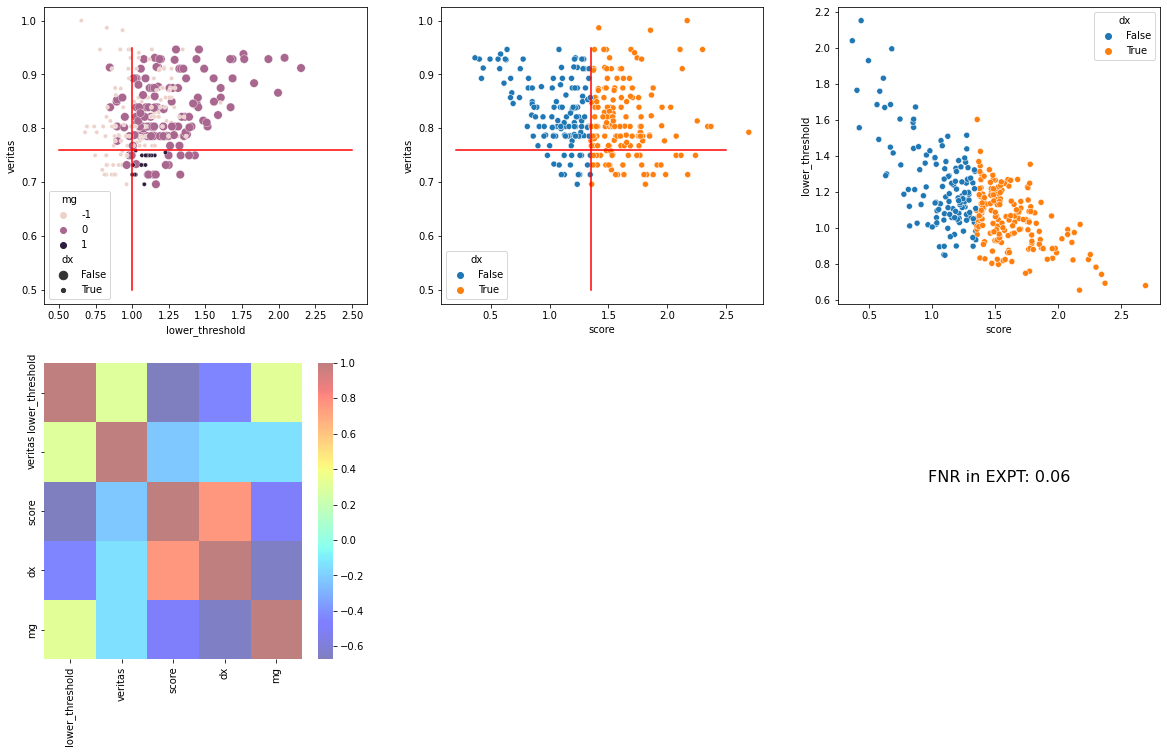

In [16]:
import pandas as pd
resf=pd.read_csv('./res_exp2_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
expd2,expf2=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid2.png',
         validation_type='fnrexpt')

In [17]:
expd2

{'fnr': 0.05806451612903226}

In [23]:
resf=expf2.join(ddf.drop(['veritas','score'],axis=1))

In [26]:
resf.columns

Index(['lower_threshold', 'veritas', 'score', 'dx', 'mg', 'Time taken', 'Age',
       'Sex', 'Ethnicity simplified', 'jsonpath', 'kappa', 'sex', 'ethnicity',
       'response'],
      dtype='object')

<AxesSubplot:xlabel='lower_threshold', ylabel='veritas'>

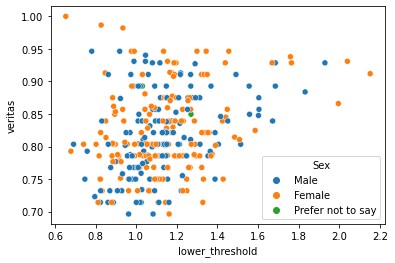

In [33]:
import seaborn as sns
sns.scatterplot(data=resf,y='veritas',x='lower_threshold',hue='Sex')

In [34]:
resf.groupby('mg').mean()

,lower_threshold,veritas,score,dx,Time taken,Age,kappa,sex,ethnicity
mg,,,,,,,,,
-1,1.044532,0.822050,1.625852,1.0,219.897436,41.448718,0.896478,0.442308,0.621795
0,1.247097,0.831626,1.065810,0.0,194.801471,40.242647,1.064329,0.455882,0.610294
1,1.086045,0.735912,1.633796,1.0,181.333333,37.277778,0.953992,0.555556,0.722222


In [35]:
resf.corr()

,lower_threshold,veritas,score,dx,mg,Time taken,Age,kappa,sex,ethnicity
lower_threshold,1.000000,0.295246,-0.674140,-0.440092,0.319511,0.013294,0.001809,0.545667,-0.021101,0.035218
veritas,0.295246,1.000000,-0.225415,-0.143931,-0.139500,0.097930,0.015750,0.009663,-0.034065,0.047233
score,-0.674140,-0.225415,1.000000,0.759512,-0.492299,0.006380,-0.011076,-0.504313,-0.002148,-0.030940
dx,-0.440092,-0.143931,0.759512,1.000000,-0.653110,0.071101,0.027129,-0.308767,-0.001853,0.009601
mg,0.319511,-0.139500,-0.492299,-0.653110,1.000000,-0.091669,-0.068581,0.239850,0.040504,0.009066
Time taken,0.013294,0.097930,0.006380,0.071101,-0.091669,1.000000,0.078561,-0.021514,0.042683,0.129054
Age,0.001809,0.015750,-0.011076,0.027129,-0.068581,0.078561,1.000000,0.072733,0.019882,-0.213852
kappa,0.545667,0.009663,-0.504313,-0.308767,0.239850,-0.021514,0.072733,1.000000,0.072432,0.013516
sex,-0.021101,-0.034065,-0.002148,-0.001853,0.040504,0.042683,0.019882,0.072432,1.000000,-0.038842
ethnicity,0.035218,0.047233,-0.030940,0.009601,0.009066,0.129054,-0.213852,0.013516,-0.038842,1.000000


In [35]:
resf.groupby(['Ethnicity simplified','Sex']).mean()

Time taken        Age  sex  ethnicity  \
Ethnicity simplified Sex                                             
Asian                Female  152.428571  33.857143  0.0        2.0   
                     Male    156.600000  42.600000  1.0        2.0   
Black                Female  245.200000  42.000000  0.0        1.0   
                     Male    685.750000  35.250000  1.0        1.0   
Mixed                Female  234.333333  32.833333  0.0        3.0   
                     Male    174.000000  21.000000  1.0        3.0   
Other                Female  257.500000  41.500000  0.0        4.0   
White                Female  172.473684  44.657895  0.0        0.0   
                     Male    178.906250  45.812500  1.0        0.0   

                             lower_threshold   veritas     score        dx  \
Ethnicity simplified Sex                                                     
Asian                Female         1.073524  0.821197  1.329887  0.285714   
                     Male           1.094925  0.822908  1.253677  0.600000   
Black                Female         1.374470  0.889286  1.120099  0.400000   
                     Male           1.097825  0.839991  1.332943  0.500000   
Mixed                Female         1.163185  0.830964  1.209657  0.333333   
                     Male           1.023984  0.759007  1.482927  1.000000   
Other                Female         1.148034  0.789946  1.433811  1.000000   
White                Female         1.119020  0.823365  1.429922  0.578947   
                     Male           1.202051  0.813081  1.277702  0.468750   

                                   mg  
Ethnicity simplified Sex               
Asian                Female -0.285714  
                     Male   -0.600000  
Black                Female -0.400000  
                     Male   -0.500000  
Mixed                Female -0.333333  
                     Male    1.000000  
Other                Female  0.000000  
White                Female -0.578947  
                     Male   -0.218750

In [37]:
resf.groupby(['Sex']).mean()

,Time taken,Age,sex,ethnicity,lower_threshold,veritas,score,dx,mg
Sex,,,,,,,,,
Female,185.655172,41.793103,0.0,0.775862,1.141120,0.828420,1.368488,0.517241,-0.482759
Male,224.404762,43.833333,1.0,0.404762,1.175132,0.815526,1.284990,0.500000,-0.261905
